In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from parse import parse
import cv2

In [2]:
train_images, train_labels = parse('facedata/facedatatrain', 'facedata/facedatatrainlabels', False)
validation_images, validation_labels = parse('facedata/facedatavalidation', 'facedata/facedatavalidationlabels', False)
test_images, test_labels = parse('facedata/facedatatest', 'facedata/facedatatestlabels', False)

In [3]:
base_rate_true = np.bincount(train_labels)/train_labels.shape[0]
print(base_rate_true)

[0.51884701 0.48115299]


In [4]:
kernel = np.ones((7,6))
images = np.swapaxes(np.swapaxes(train_images, 0, 2), 0, 1)
dst = cv2.filter2D(src = images, ddepth = -1, kernel = kernel, anchor = (0,0))
zones = dst[::7,::6,:]

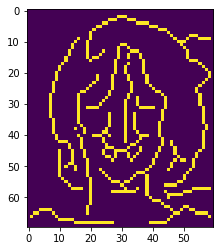

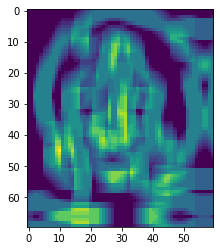

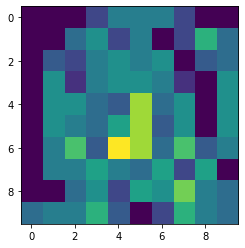

In [5]:
a = 0
plt.imshow(train_images[a,:,:])
plt.show()
plt.imshow(dst[:,:,a])
plt.show()
plt.imshow(dst[::7,::6,a])

In [6]:
def get_feature_probs(images = train_images, labels = train_labels, dim = (3,3), stride = -1, kernel = -1):

    labels = labels.astype(bool)

    if stride == -1:
        stride = dim

    if kernel == -1:
        kernel = np.ones(dim)

    pixel_quant = dim[0]*dim[1] + 1

    kernel = np.ones(dim)
    images = np.swapaxes(np.swapaxes(images, 0, 2), 0, 1)
    dst = cv2.filter2D(src = images, ddepth = -1, kernel = kernel, anchor = (0,0))

    zones = dst[::stride[0],::stride[1],:].astype(int)
    zones = np.reshape(zones, (zones.shape[0]*zones.shape[1], zones.shape[2]))

    zone_probs = np.zeros((zones.shape[0], pixel_quant, 2))

    for i, zone in enumerate(zones):
        quant_false = np.bincount(zone[np.invert(labels)])
        quant_false = np.pad(quant_false, (0, pixel_quant - quant_false.shape[0]), constant_values = 0)
        quant_false = quant_false/np.sum(quant_false)

        quant_true = np.bincount(zone[labels])
        quant_true = np.pad(quant_true, (0, pixel_quant - quant_true.shape[0]), constant_values = 0)
        quant_true = quant_true/np.sum(quant_true)

        zone_probs[i, :, 0], zone_probs[i, :, 1] = quant_false, quant_true

        zeros = zone_probs == 0
        zone_probs[zeros] = 0.000001

    return zone_probs

In [7]:
def get_features(images = train_images, dim = (3,3), stride = -1, kernel = -1):
    if stride == -1:
        stride = dim

    if kernel == -1:
        kernel = np.ones(dim)

    pixel_quant = dim[0]*dim[1] + 1

    kernel = np.ones(dim)
    images = np.swapaxes(np.swapaxes(images, 0, 2), 0, 1)
    dst = cv2.filter2D(src = images, ddepth = -1, kernel = kernel, anchor = (0,0))

    zones = dst[::stride[0],::stride[1],:].astype(int)
    zones = np.reshape(zones, (zones.shape[0]*zones.shape[1], zones.shape[2]))
    #zones = np.swapaxes(zones, 0, 1)

    return zones

In [8]:
def main(train_images = train_images, train_labels = train_labels, test_images = validation_images, test_labels = validation_labels):
    
    dim = (7,3)

    base_rate_true = np.bincount(train_labels)/train_labels.shape[0]

    t_begin = time.time()
    feature_probs = get_feature_probs(train_images, train_labels, dim)
    t_end = time.time() - t_begin
    train_features = get_features(train_images, dim)
    test_features = get_features(test_images, dim)

    train_image_probs = np.product(feature_probs[np.arange(len(train_features))[:, np.newaxis], train_features], axis = 0)
    train_preds = train_image_probs[:,0]*base_rate_true[0] < train_image_probs[:,1]*base_rate_true[1]
    train_acc = np.sum(train_preds == train_labels)/train_labels.shape[0]

    test_image_probs = np.product(feature_probs[np.arange(len(test_features))[:, np.newaxis], test_features], axis = 0)
    test_preds = test_image_probs[:,0]*base_rate_true[0] < test_image_probs[:,1]*base_rate_true[1]
    test_acc = np.sum(test_preds == test_labels)/test_labels.shape[0]

    return feature_probs, train_acc, test_acc, t_end

In [9]:
mean_acc = np.zeros((10, 2), dtype= np.float64)
std = np.zeros((10, 2), dtype= np.float64)
time_func = np.zeros((10, 1), dtype = np.float64)
models = []
iterations = 12

for i in range(1, 11):
    accuracy = np.zeros((iterations, 2), dtype= np.float64)
    avg_time = np.zeros((iterations, 1), dtype= np.float64)

    for iteration in range(0, iterations):

        ammount = int(0.1 * i * train_images.shape[0] )
        available_indices = np.random.choice(train_images.shape[0], ammount, replace = False)
        available_images = train_images[available_indices]
        available_labels = train_labels[available_indices]

        model, train_acc, test_acc, t = main(available_images, available_labels, test_images, test_labels)
        accuracy[iteration] = train_acc, test_acc
        avg_time[iteration] = t

        if i == 10:
            models.append(model)

    mean_acc[i-1] = np.mean(accuracy, axis = 0)
    std[i-1] = np.std(accuracy, axis = 0)
    time_func[i-1] = np.mean(avg_time)

In [10]:
print(f"Average results with all training data over {iterations} runs")
print("Accuracy: Train = {:.4f}, Test = {:.4f}".format(mean_acc[-1,0], mean_acc[-1,1]))
print("StD: Train = {:.1f}, Test = {:.1f}; should be 0".format(std[-1,0], std[-1,1]))
print("Runtime = {:.3f} seconds".format(time_func[-1][0]))

Average results with all training data over 12 runs
Accuracy: Train = 0.9889, Test = 0.9267
StD: Train = 0.0, Test = 0.0; should be 0
Runtime = 0.026 seconds


[[1.         0.75388889]
 [1.         0.76388889]
 [0.99876543 0.81222222]
 [0.99675926 0.85166667]
 [0.99592593 0.89166667]
 [0.99290123 0.90166667]
 [0.99365079 0.90111111]
 [0.98981481 0.91222222]
 [0.99074074 0.91611111]
 [0.98891353 0.92666667]]


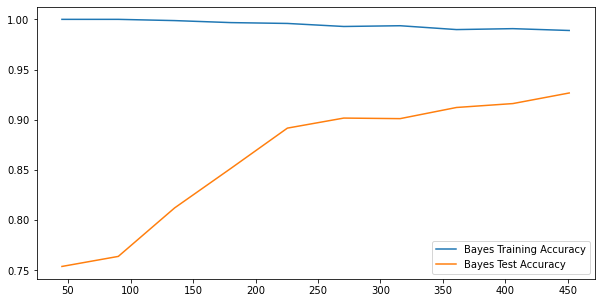

In [14]:
plt.figure(figsize = (10, 5))
x = np.linspace(.1*train_images.shape[0], train_images.shape[0], 10)
plt.plot(x, mean_acc[:,0], label = "Bayes Training Accuracy")
plt.plot(x, mean_acc[:,1], label = "Bayes Test Accuracy")
print(mean_acc)
plt.legend()

[[0.00000000e+00 6.11893439e-02]
 [0.00000000e+00 8.93788579e-02]
 [2.76057775e-03 3.53640677e-02]
 [4.21779332e-03 3.17542648e-02]
 [4.23908265e-03 1.28019096e-02]
 [4.88980849e-03 1.41748342e-02]
 [3.88807896e-03 2.06977067e-02]
 [3.27364251e-03 1.11665285e-02]
 [2.28200340e-03 6.35862397e-03]
 [1.11022302e-16 2.22044605e-16]]


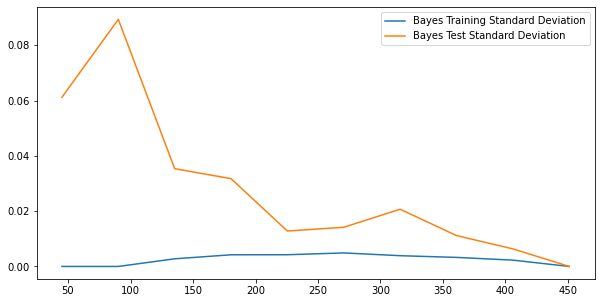

In [15]:
plt.figure(figsize = (10, 5))
x = np.linspace(.1*train_images.shape[0], train_images.shape[0], 10)
plt.plot(x, std[:,0], label = "Bayes Training Standard Deviation")
plt.plot(x, std[:,1], label = "Bayes Test Standard Deviation")
print(std)
plt.legend()

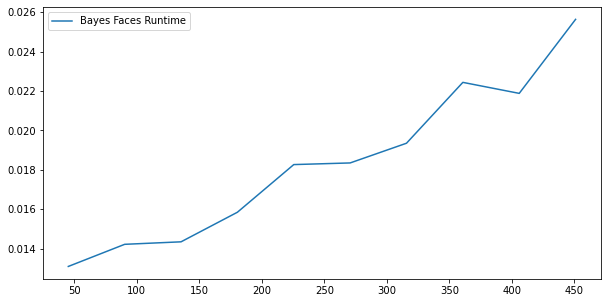

In [13]:
plt.figure(figsize = (10, 5))
x = np.linspace(.1*train_images.shape[0], train_images.shape[0], 10)
plt.plot(x, time_func, label = "Bayes Faces Runtime")
plt.legend()